In [3]:
import sys
sys.path.append("../src")
from importlib import reload
import brownian
reload(brownian)
from brownian import make_sim_params, sim2
import numpy as np
import matplotlib.pyplot as plt
import time
from joblib import Parallel, delayed


In [4]:
def flattop(x, t, R, c, d, P0, X0, **kwarg):
    xprime = x - c*t
    if np.abs(xprime-X0) <= d/2:
        return P0 * np.pi * R*R
    else:
        return 0.0
    
def halfsin(x, t, R, c, d, P0, X0, **kwarg):
    xprime = x - c*t
    if np.abs(xprime-X0) <= d/2:
        return P0 * np.pi * R*R * np.cos(np.pi*(xprime-X0)/(d))
    else:
        return 0.0
    
def fullsin(x, t, R, c, d, P0, X0, **kwarg):
    xprime = x - c*t
    if np.abs(xprime-X0) <= d/2:
        return P0 * np.pi * R*R * np.sin(np.pi*(xprime-X0)/(d/2))
    else:
        return 0.0
    
def Nwave(x, t, R, c, d, P0, X0, **kwargs):
    xprime = x - c*t
    if np.abs(xprime-X0) <= d/2:
        return np.pi * R*R * (xprime - X0) * 2*P0 / d
    else:
        return 0.0
    

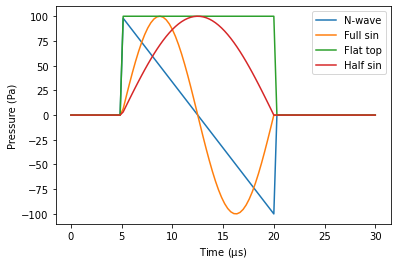

In [6]:
c = 344.7
params = dict(
    X0 = -c * 12.5e-6,
    c = c ,
    d = 15e-6 * c,
    P0 = 100,
    R = 3.17e-6 / 2
)

ts = np.linspace(0, 2*params["d"]/params["c"], 100)

plt.plot(ts*1e6, [Nwave(0, t, **params) / (np.pi*params["R"]**2) for t in ts], label="N-wave")
plt.plot(ts*1e6, [fullsin(0, t, **params) / (np.pi*params["R"]**2) for t in ts], label="Full sin")
plt.plot(ts*1e6, [flattop(0, t, **params) / (np.pi*params["R"]**2) for t in ts], label="Flat top")
plt.plot(ts*1e6, [halfsin(0, t, **params) / (np.pi*params["R"]**2) for t in ts], label="Half sin")
plt.ylabel("Pressure (Pa)")
plt.xlabel(r"Time (${\rm \mu s}$)")
plt.legend()
plt.savefig("../figures/pressure_profile_temporal.pdf", bbox_inches="tight")

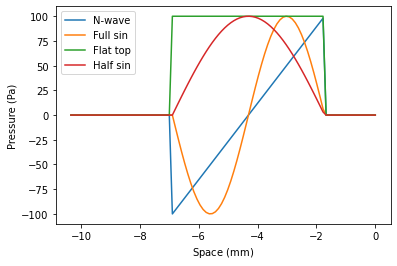

In [1414]:
xs = -ts*c
plt.plot(xs*1e3, [Nwave(x, 0, **params) / (np.pi*params["R"]**2) for x in xs], label="N-wave")
plt.plot(xs*1e3, [fullsin(x, 0, **params) / (np.pi*params["R"]**2) for x in xs], label="Full sin")
plt.plot(xs*1e3, [flattop(x, 0, **params) / (np.pi*params["R"]**2) for x in xs], label="Flat top")
plt.plot(xs*1e3, [halfsin(x, 0, **params) / (np.pi*params["R"]**2) for x in xs], label="Half sin")
plt.ylabel("Pressure (Pa)")
plt.xlabel(r"Space (${\rm mm}$)")
plt.legend()
plt.savefig("../figures/pressure_profile_spatial.pdf", bbox_inches="tight")

In [1376]:
class Sim:
    def __init__(self, params):
        self.params = params
            
    def run(self, dt=None, tmax=None, N=None, **kwargs):
        if dt is None:
            dt = self.params["dt"]
        if tmax is None:
            tmax = self.params["tmax"]
        if N is None:
            N = self.params["N"]
        self.xsbar = 0
        self.vsbar = 0
        self.asbar = 0
        for i in range(N):
            xs, _, txs = sim2(**self.params)
            xs = xs[:,0]
            tvs, vs = firstdiff((txs, xs), acc=8)
            self.ts, acs = firstdiff((tvs, vs), acc=8)
            self.xsbar += xs[8:-8] / N
            self.vsbar += vs[4:-4] / N
            self.asbar += acs / N

        self.Ftot = self.asbar * self.params["m"]
        self.Fpulse = self.Ftot - ( -self.params["K"][0] * self.xsbar - self.params["gamma"] * self.vsbar)
        self.E = (self.params["K"][0] * self.xsbar**2 + self.params["m"] * self.vsbar**2) / 2

def workload(sim, print_str):
    print(print_str)
    took = time.time()
    sim.run(**sim.params)
    took = time.time() - took
    print(f"  took {round(took, 1)} s")
    return sim


In [1377]:
50*np.max(fs) * 1e-6

10.0

In [1385]:
fs = np.geomspace(1e3, 200e3, 50)
P0s = np.geomspace(5, 100, 5)
fields = [flattop, halfsin, fullsin, Nwave]
N = 1
c = 344.7
shape = (len(fields), len(fs), len(P0s))
n_jobs = 2

sims_flat = []
params_arr = np.zeros(shape, dtype="object")
for fieldi, field in enumerate(fields):
    for fi, f in enumerate(fs):
        for P0i, P0 in enumerate(P0s):
            d = 1 / f
            X0 = -d*1.25
            tmax =  5*d/c
            dt = 1 / 1000e6
            params = make_sim_params(
                         K=np.array([20e-6]), 
                         rho =1400,
                         R = 3.17e-6 / 2,
                         T = 20 + 273.15,
                         field=field,
                         field_params = dict(c=c, d=d, P0=P0, X0=X0)
                         )
            
            params["dt"] = dt
            params["tmax"] = tmax
            params["N"] = N
            sims_flat.append(Sim(params))
            
sims_flat = Parallel(n_jobs=n_jobs)(delayed(workload)(S, f"{Si+1}/{len(sims_flat)}") for Si, S in enumerate(sims_flat))
sims = np.array(sims_flat, dtype="object").reshape(*shape)

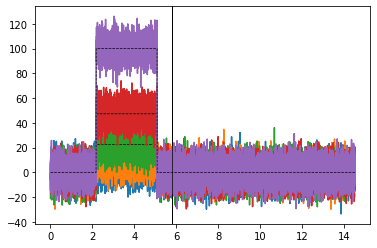

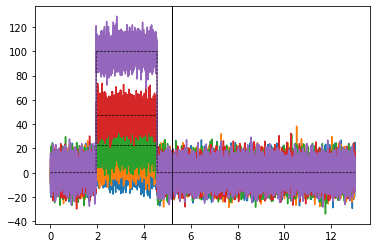

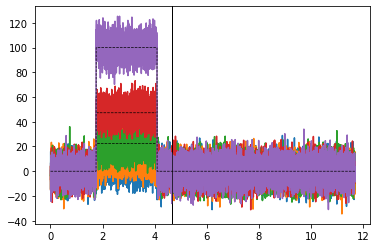

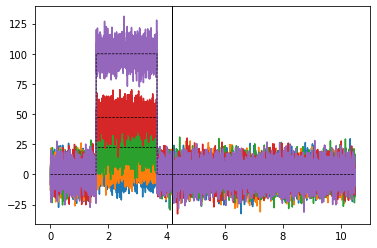

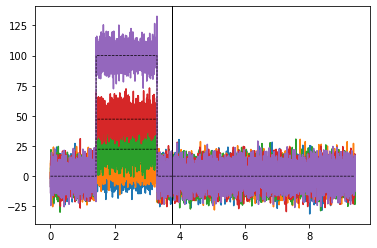

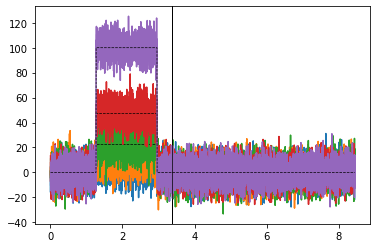

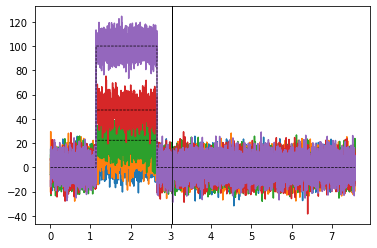

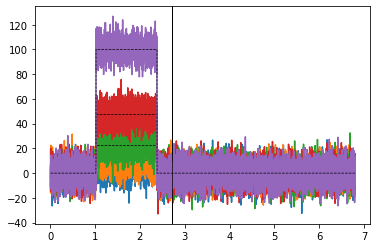

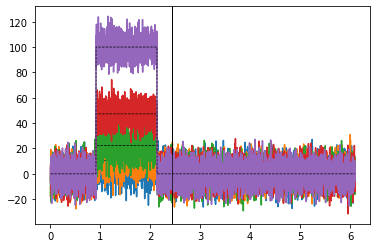

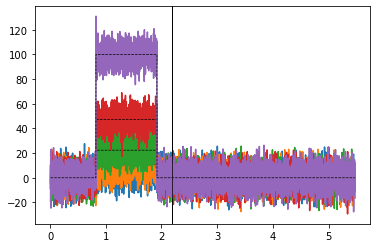

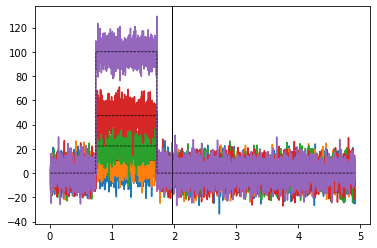

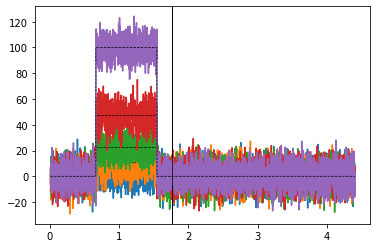

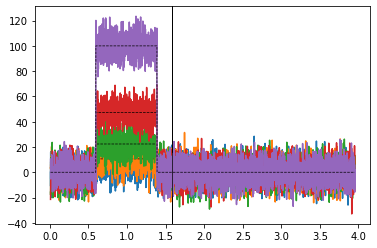

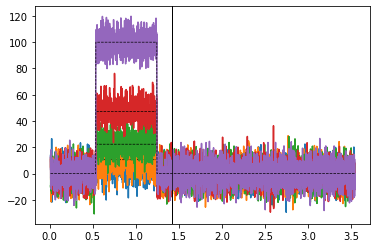

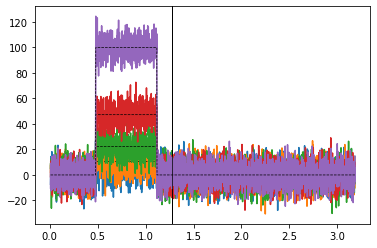

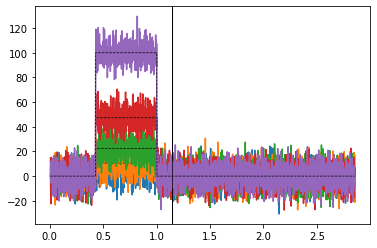

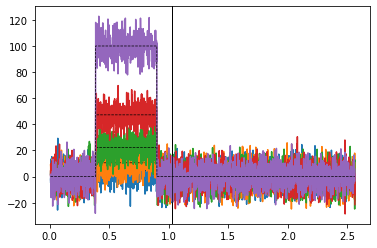

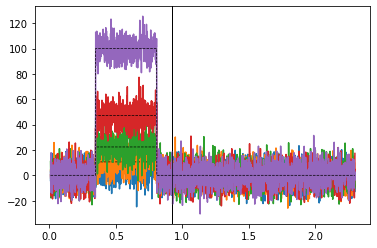

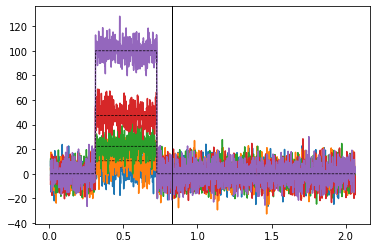

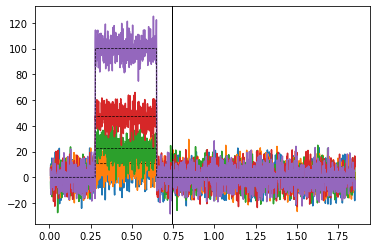

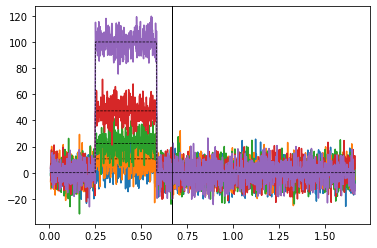

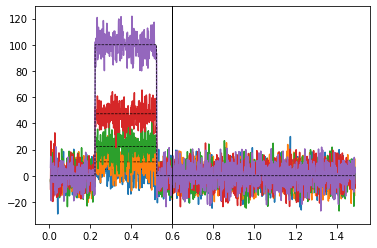

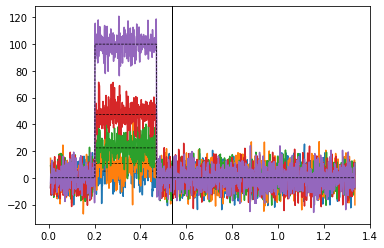

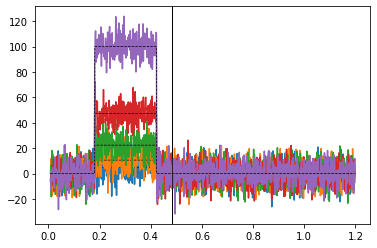

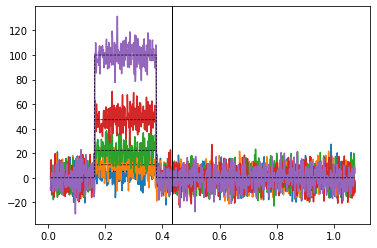

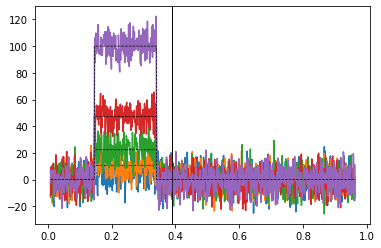

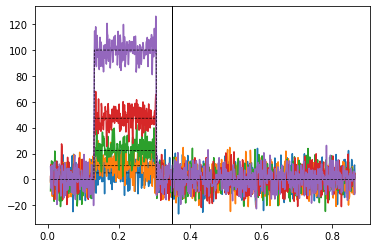

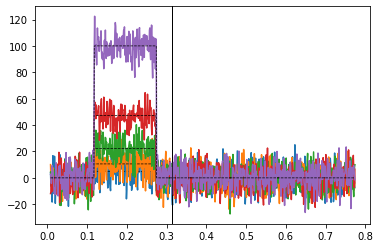

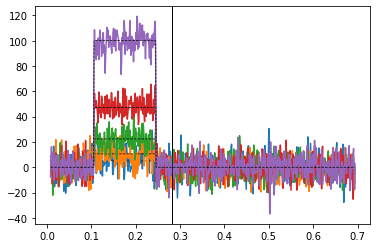

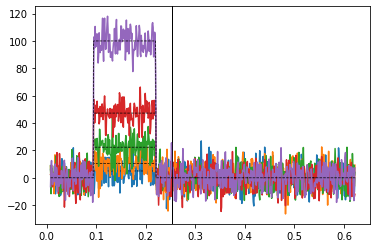

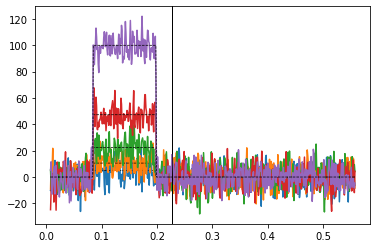

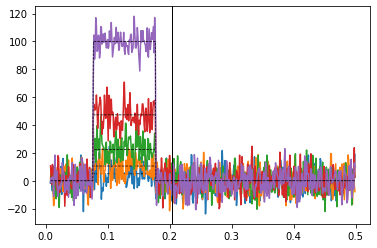

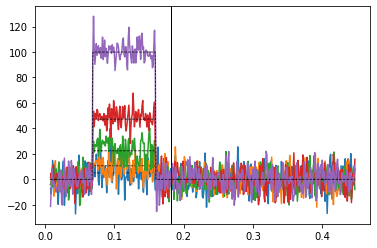

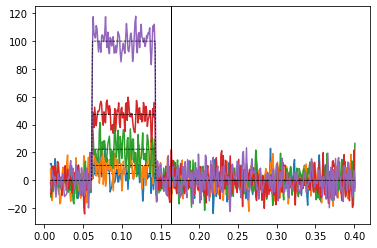

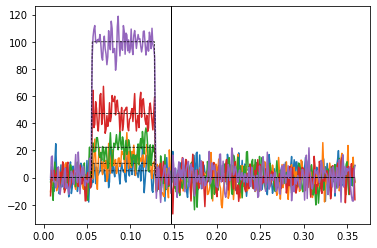

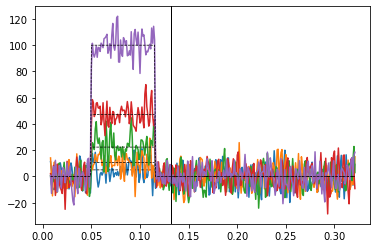

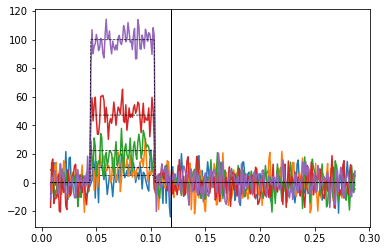

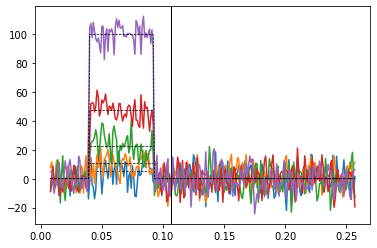

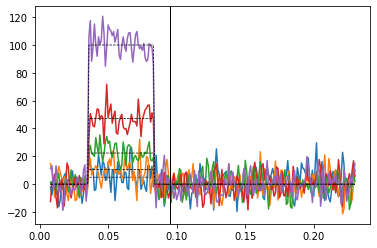

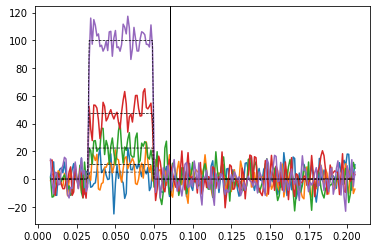

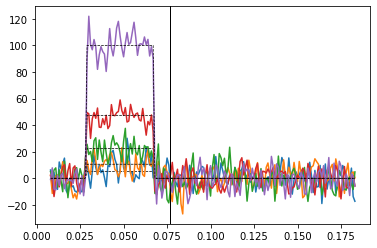

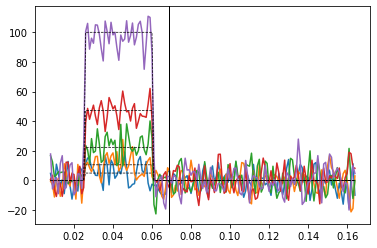

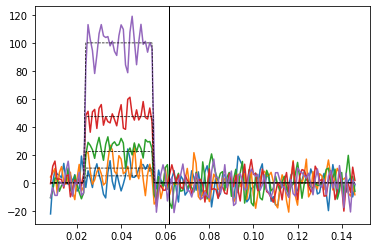

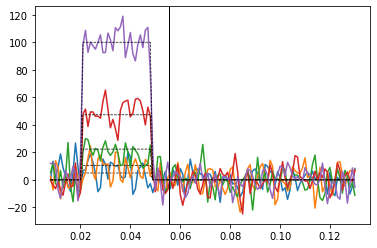

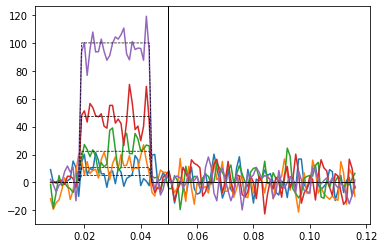

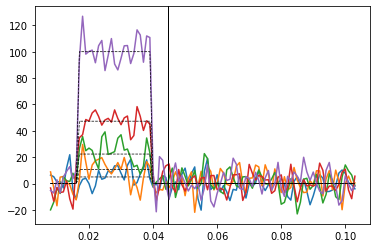

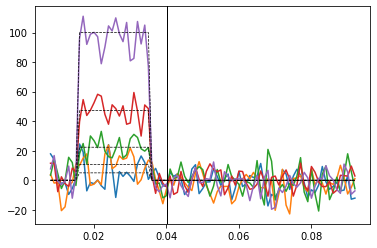

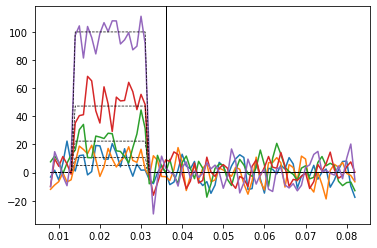

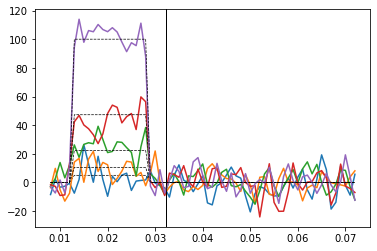

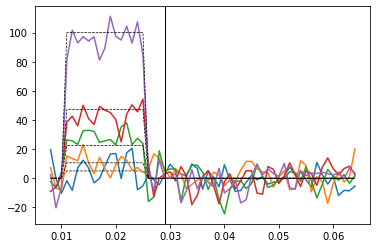

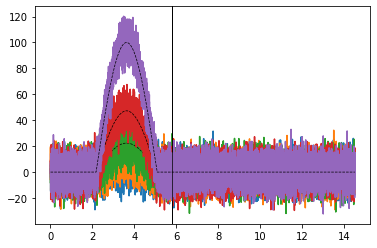

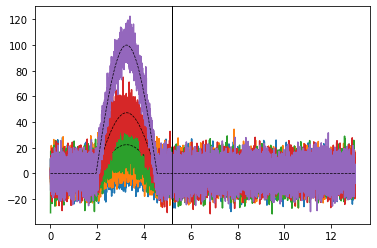

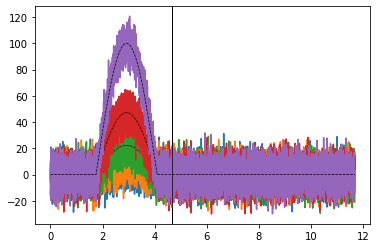

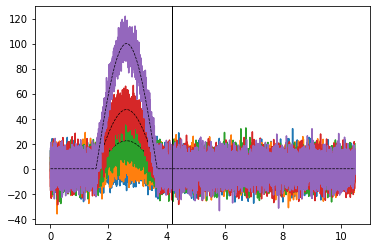

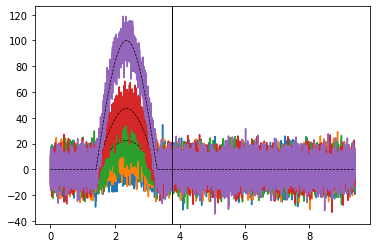

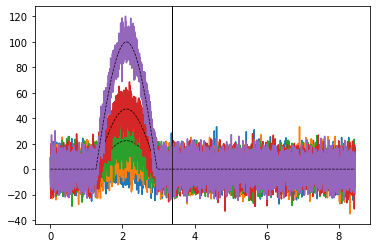

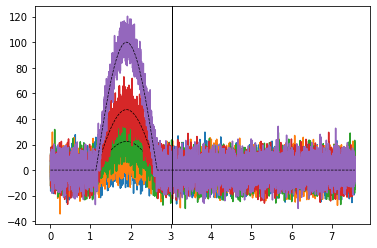

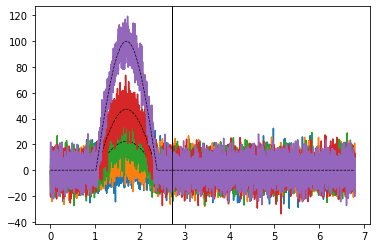

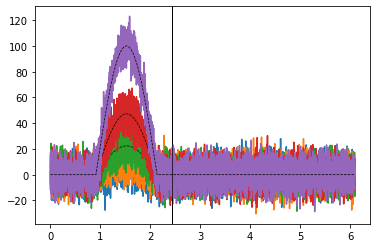

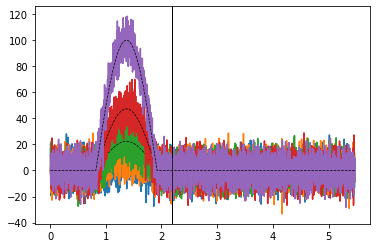

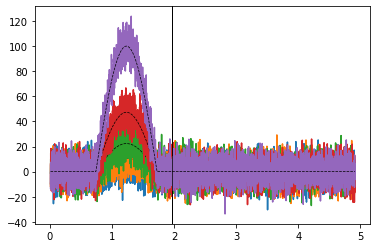

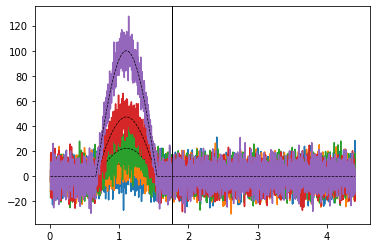

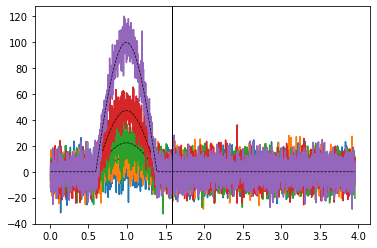

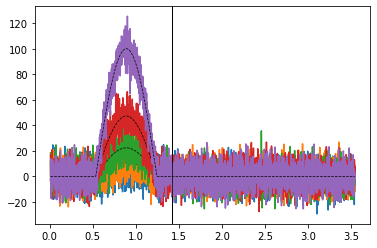

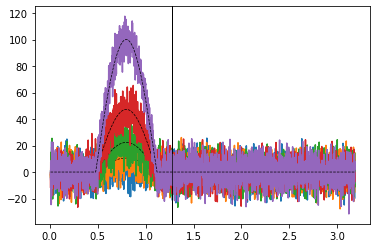

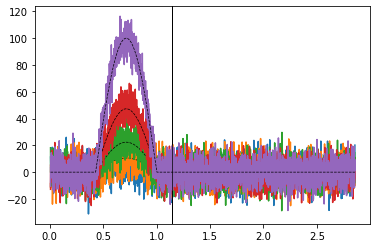

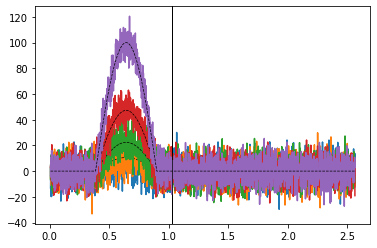

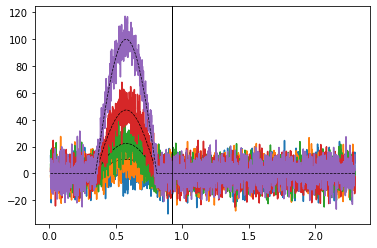

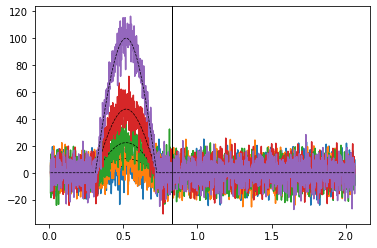

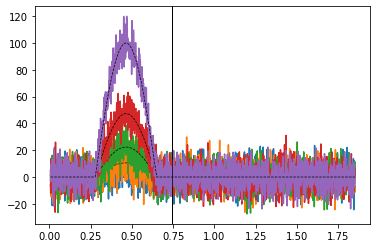

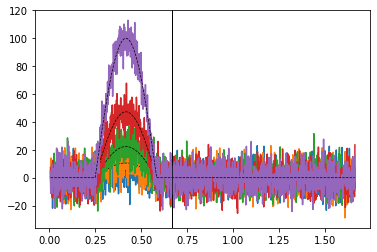

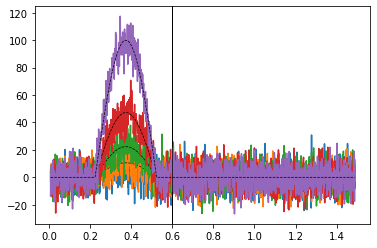

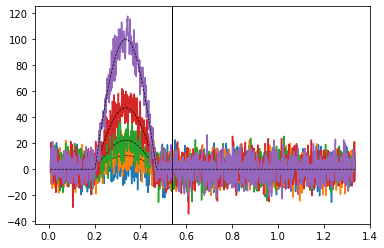

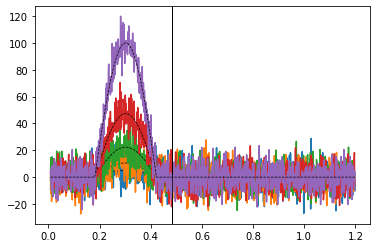

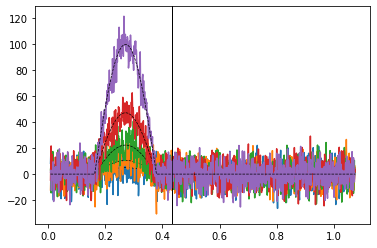

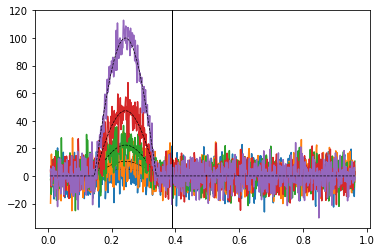

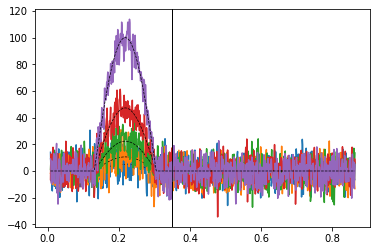

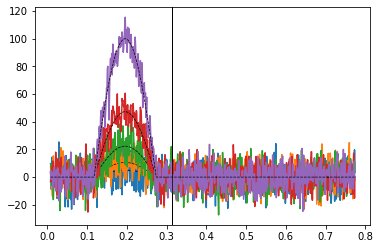

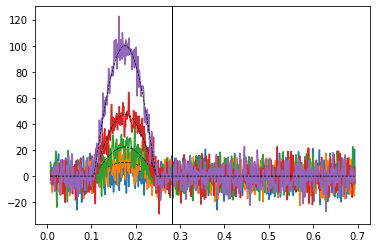

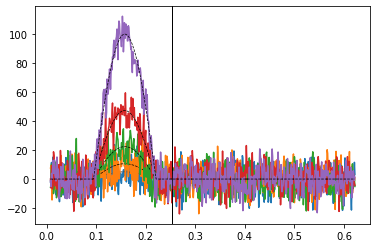

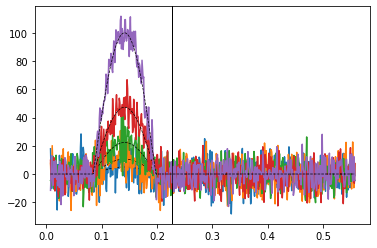

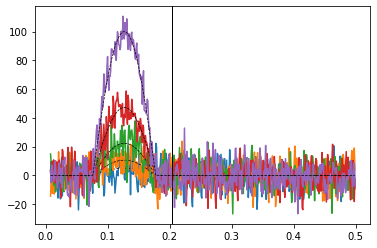

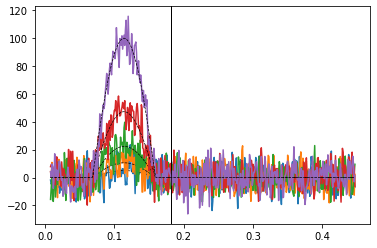

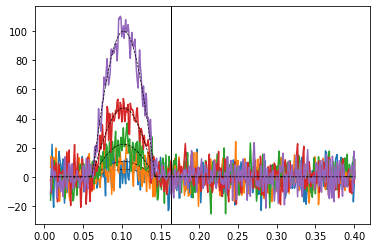

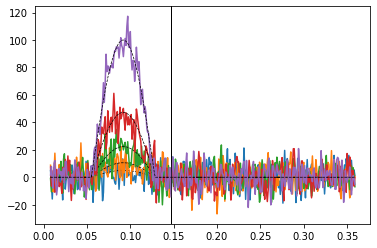

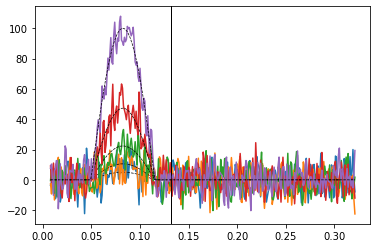

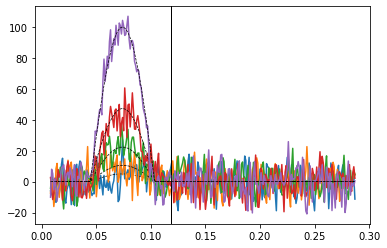

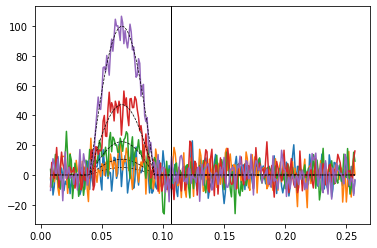

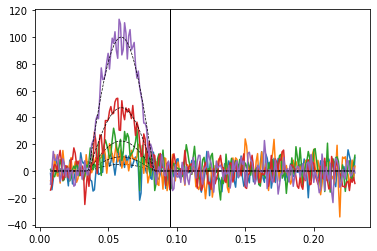

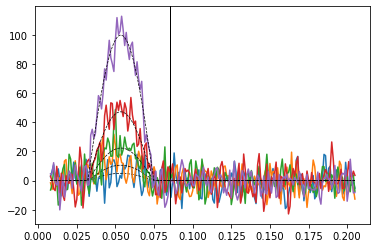

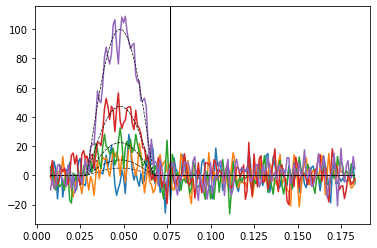

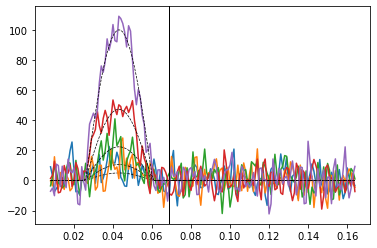

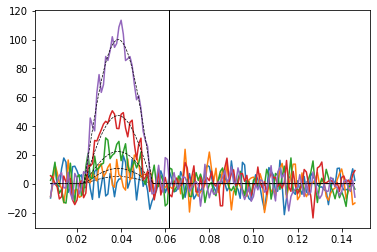

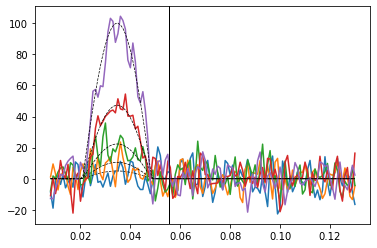

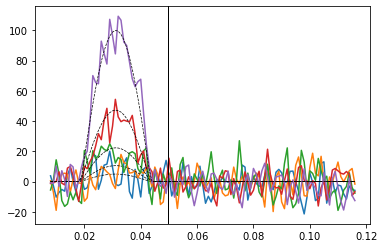

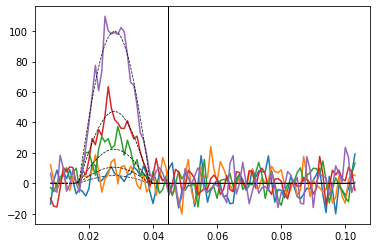

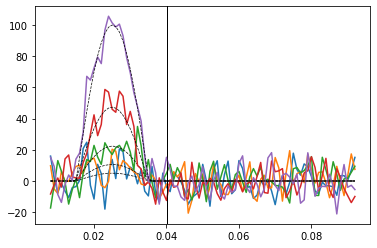

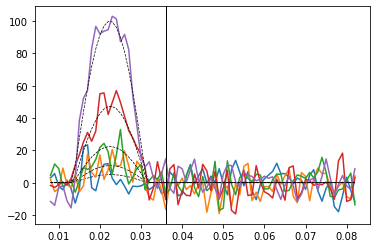

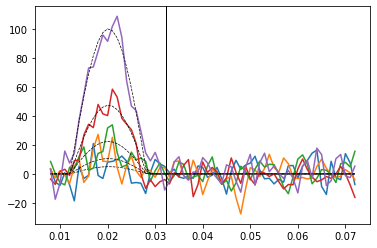

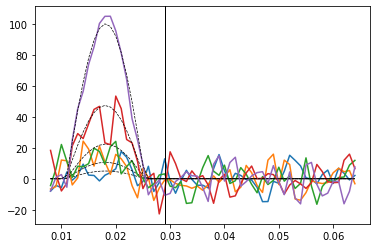

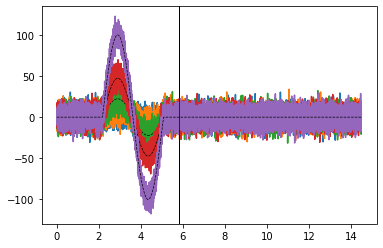

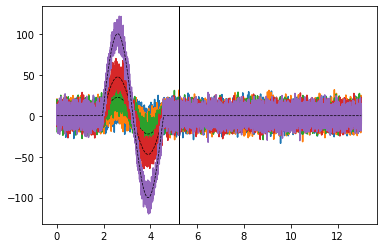

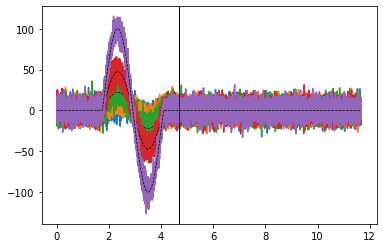

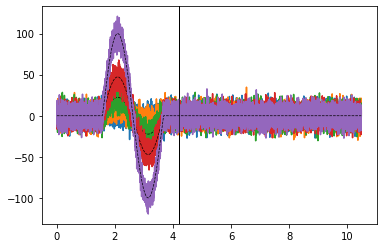

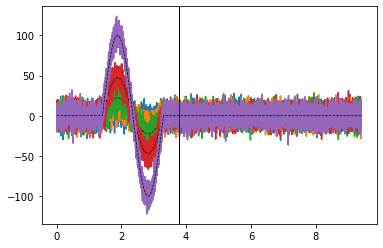

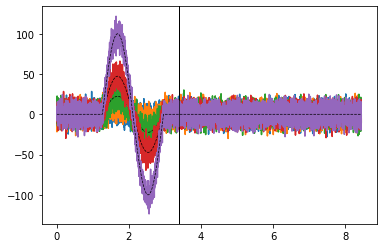

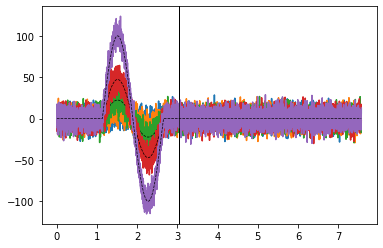

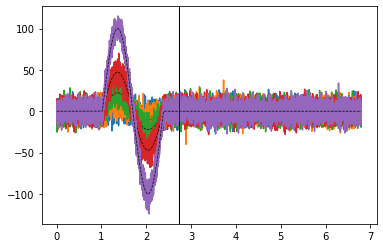

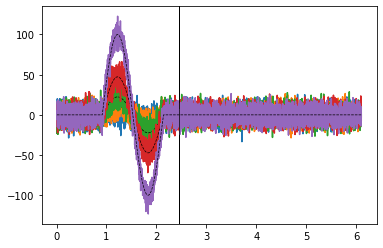

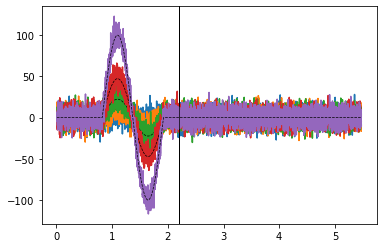

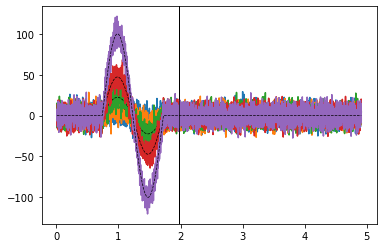

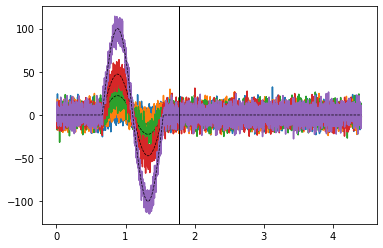

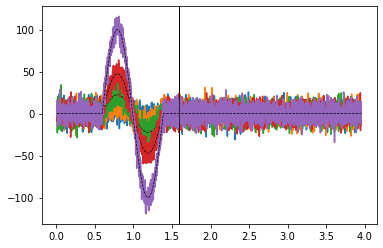

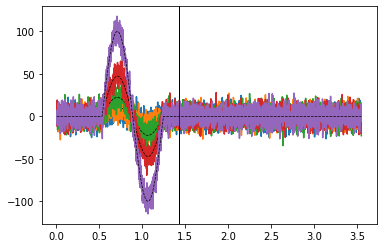

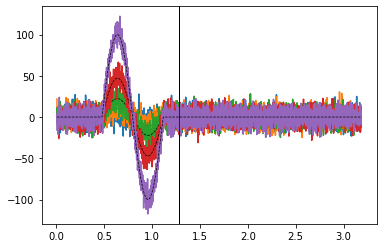

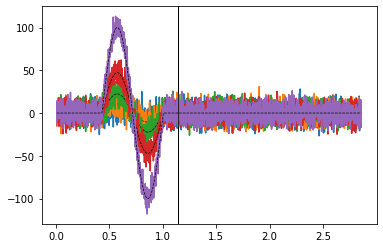

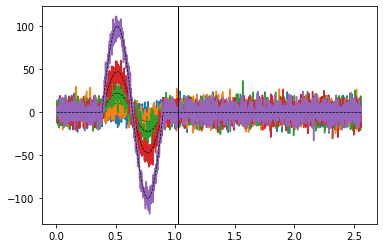

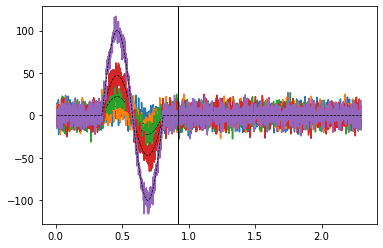

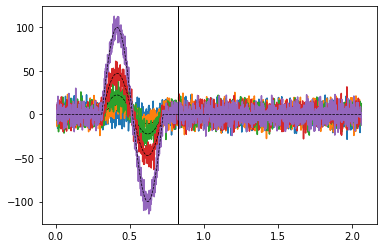

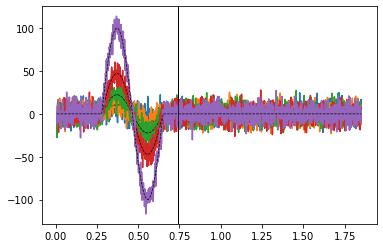

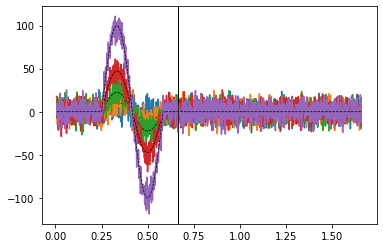

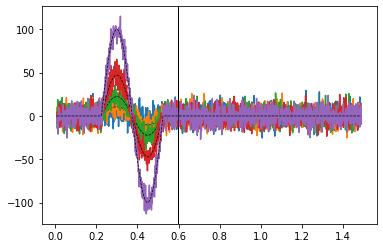

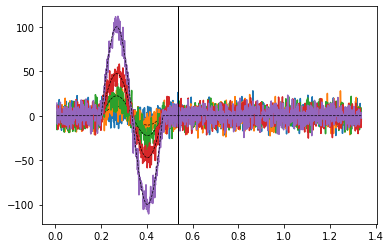

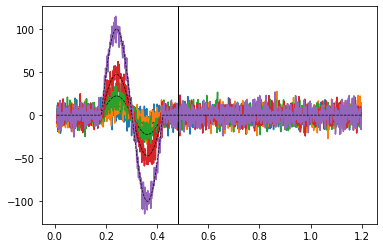

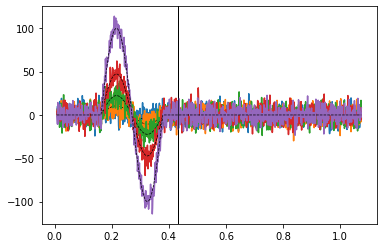

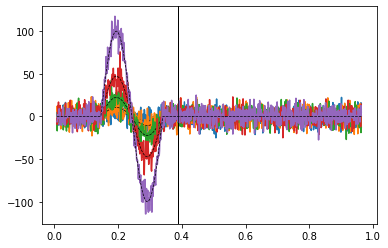

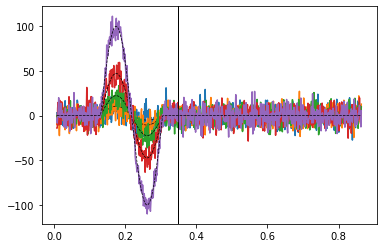

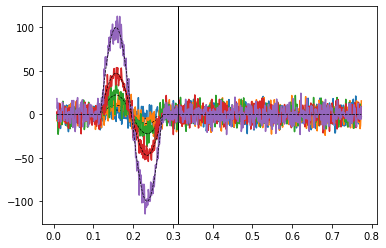

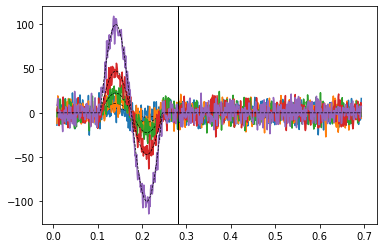

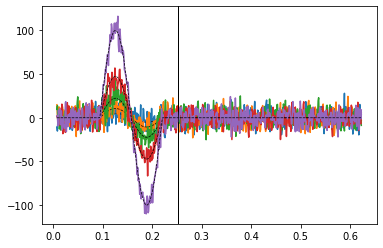

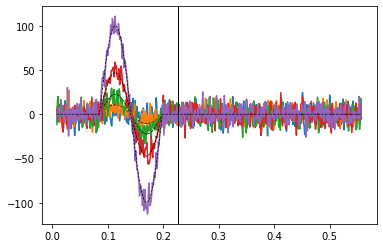

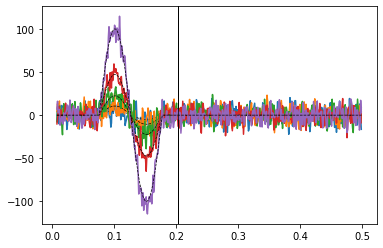

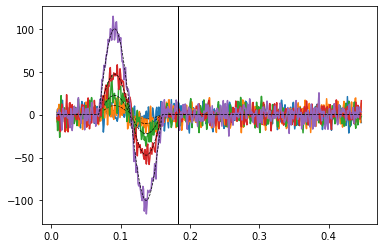

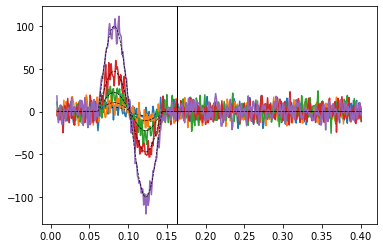

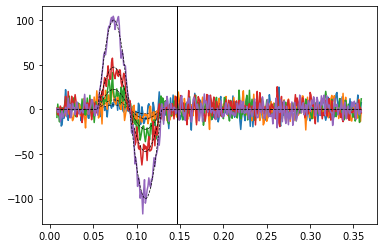

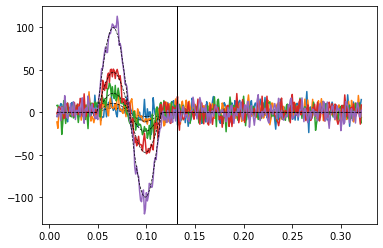

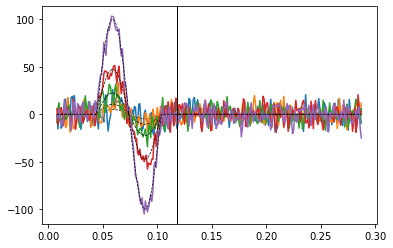

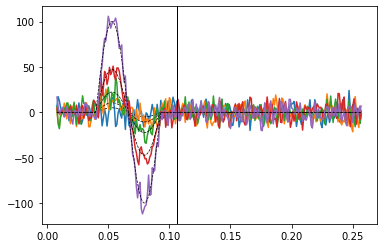

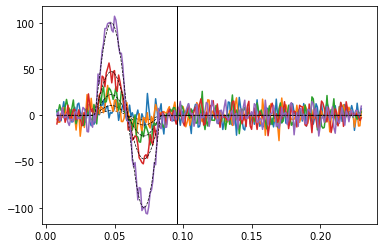

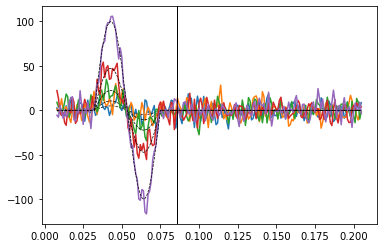

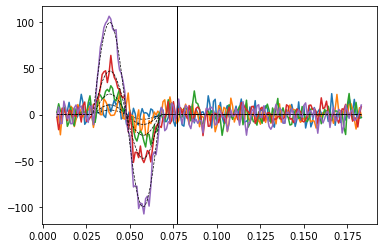

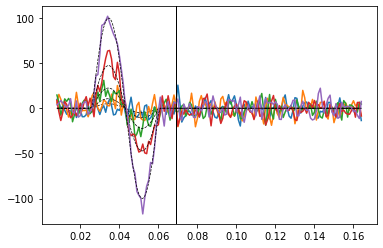

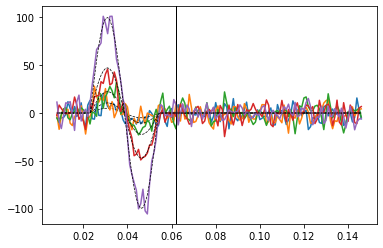

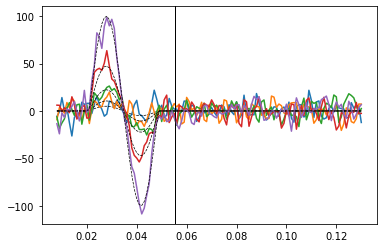

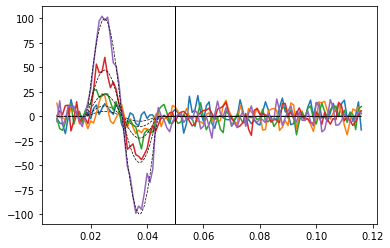

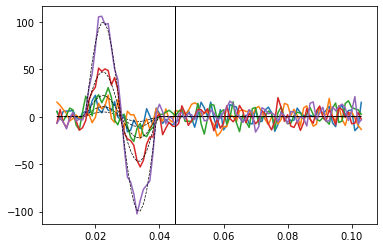

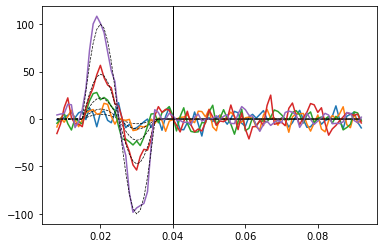

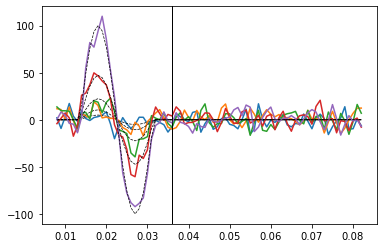

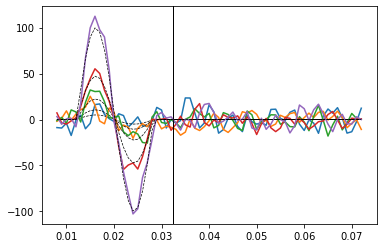

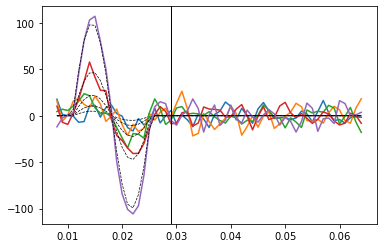

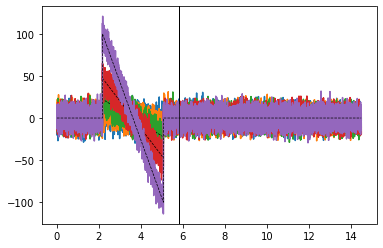

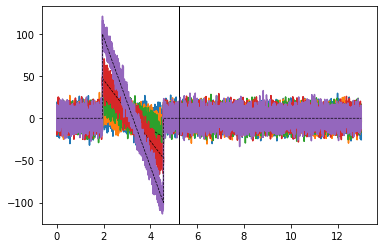

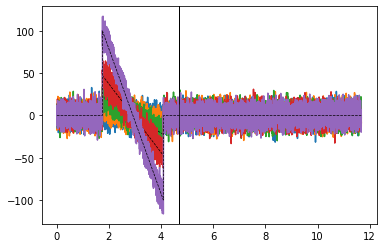

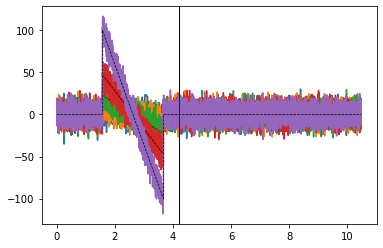

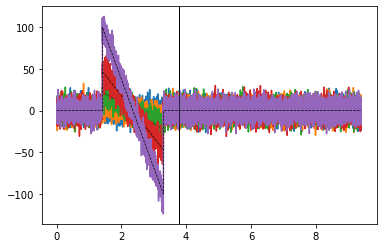

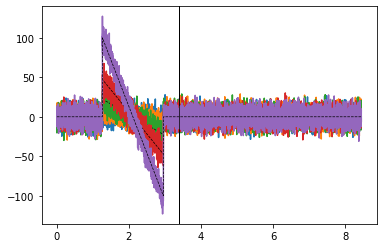

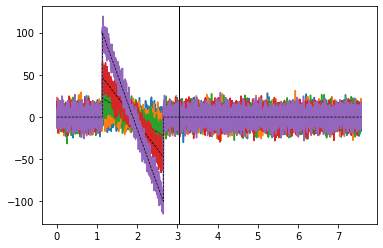

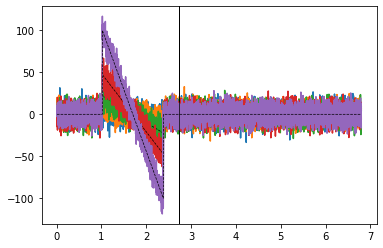

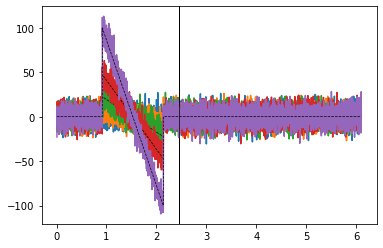

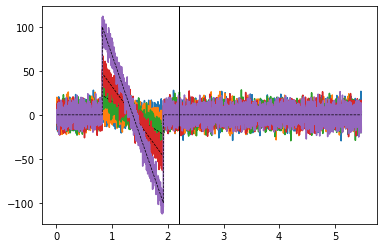

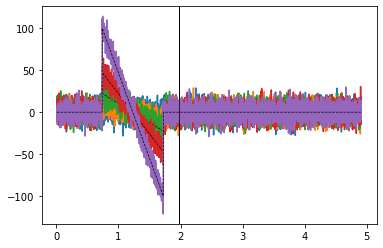

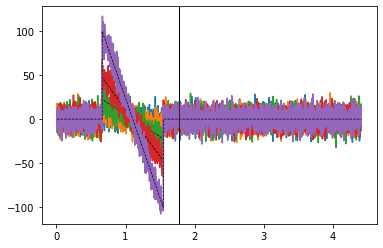

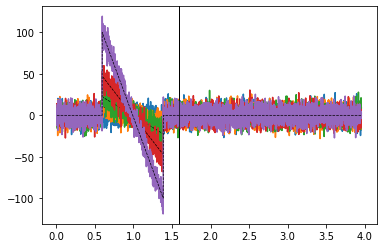

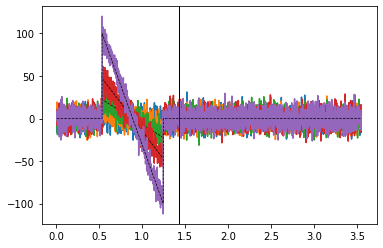

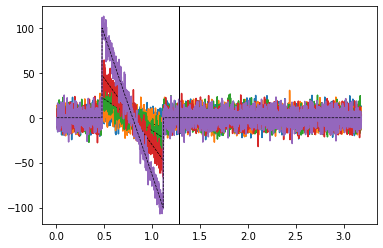

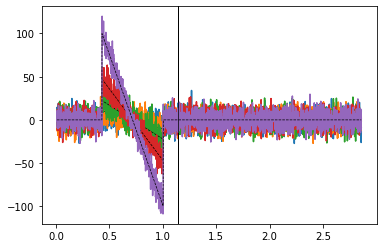

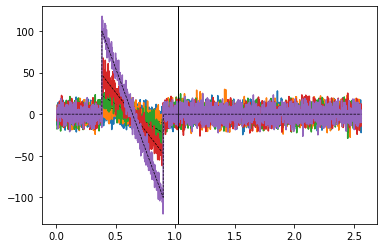

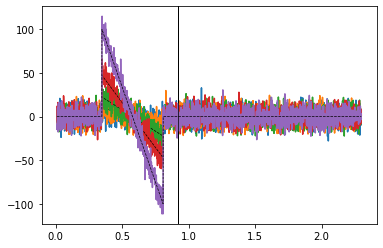

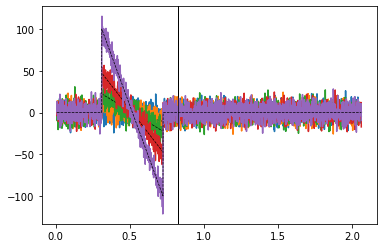

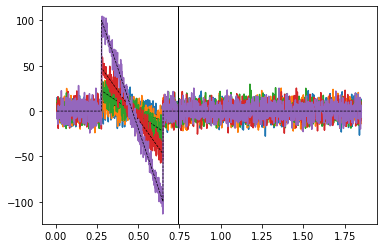

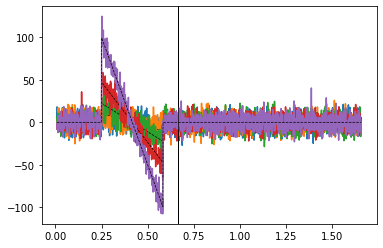

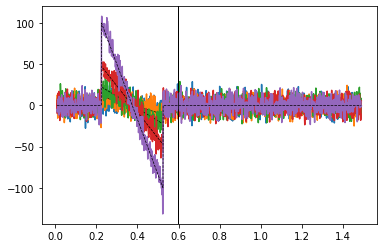

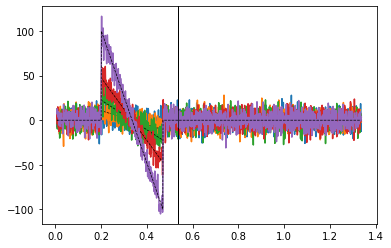

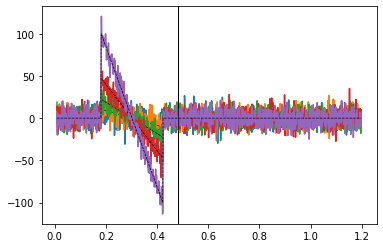

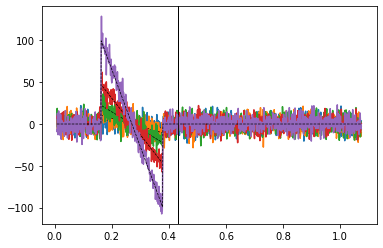

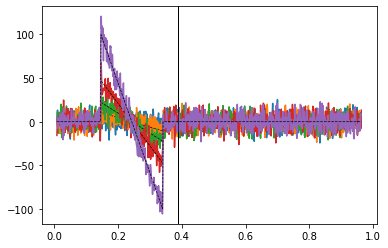

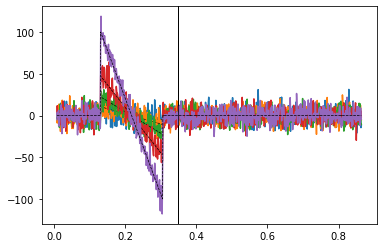

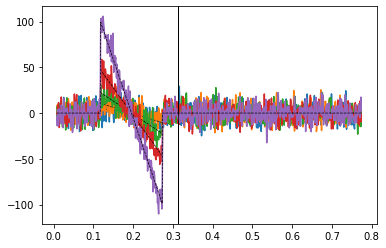

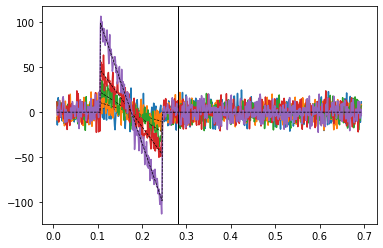

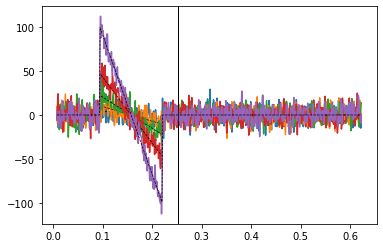

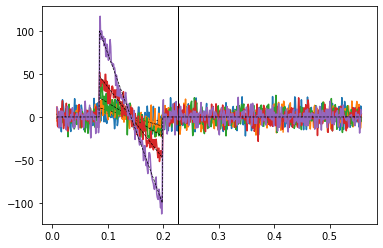

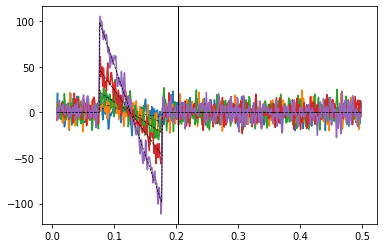

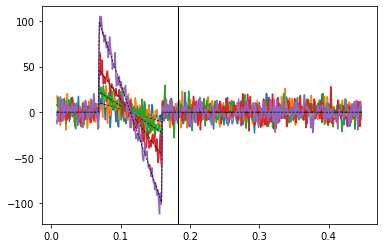

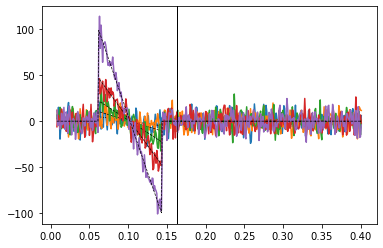

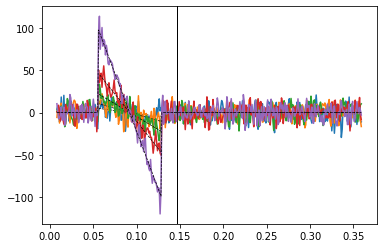

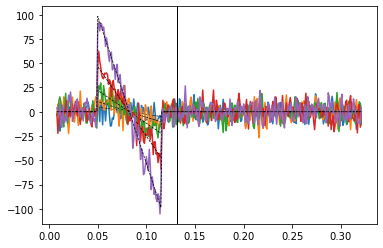

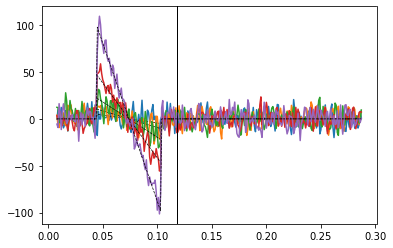

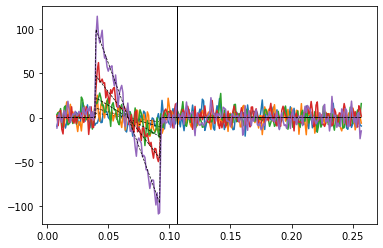

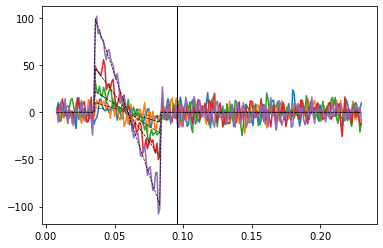

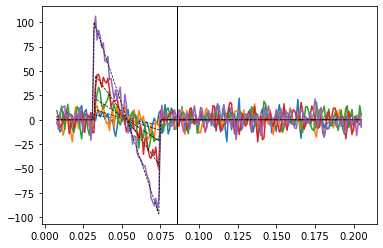

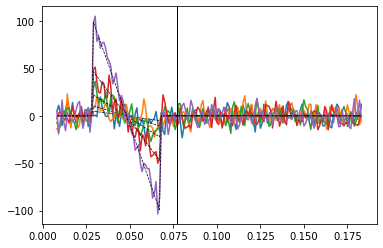

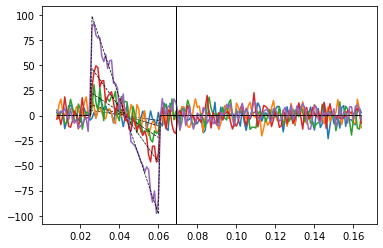

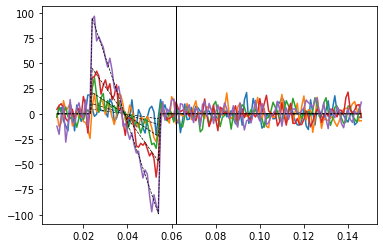

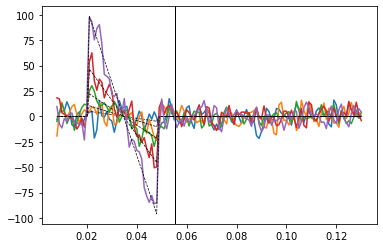

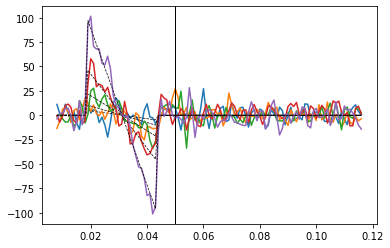

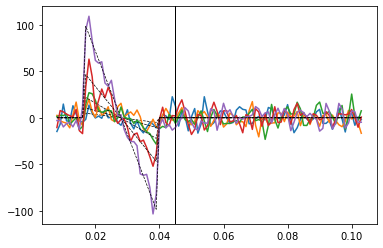

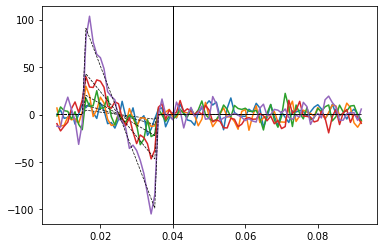

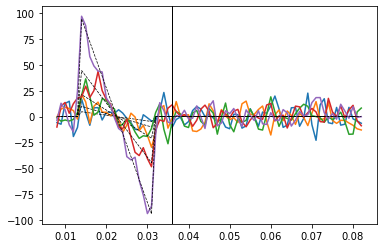

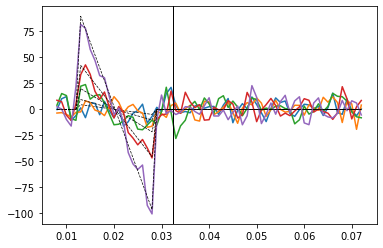

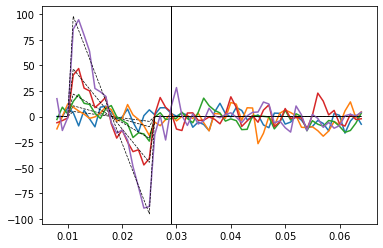

In [1386]:
for fieldi, field in enumerate(fields):
    for fi, f in enumerate(fs):
        for P0i, P0 in enumerate(P0s):
            S = sims[fieldi, fi, P0i]
            plt.plot(5*S.params["dt"]+S.ts*1e6, S.Fpulse / (np.pi*params["R"]**2))
            plt.plot(S.ts*1e6, [field(x, t, **S.params) / (np.pi*params["R"]**2) for x,t in zip(S.xsbar,S.ts)], c="k", ls="--", lw=0.7)
            plt.axvline(1e6*2*S.params["d"]/S.params["c"], c="k", lw=0.7)
        plt.show()

In [1387]:
SNRs = np.zeros(shape)
dts = []
for fieldi, field in enumerate(fields):
    for fi, f in enumerate(fs):
        for P0i, P0 in enumerate(P0s):
            S = sims[fieldi, fi, P0i]
            a = S.Fpulse
            mask = S.ts<2*S.params["d"]/S.params["c"]
            SNRs[fieldi, fi, P0i] = np.max(a[mask]) / np.std(a[~mask])
            dts.append(S.params["dt"])

10.57371263440564
22.360679774997894
47.28708045015879
100.0
10.57371263440564
22.360679774997894
47.28708045015879
100.0
10.57371263440564
22.360679774997894
47.28708045015879
100.0
10.57371263440564
22.360679774997894
47.28708045015879
100.0


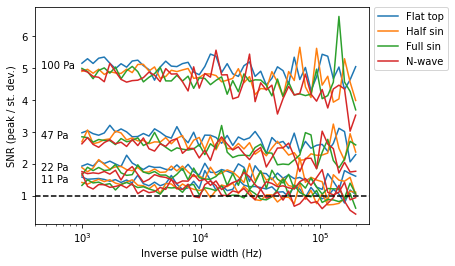

In [1448]:
snrbar = 0
names = ["Flat top", "Half sin", "Full sin", "N-wave"]
for fieldi, field in enumerate(fields):
    for P0i, P0 in enumerate(P0s[1:]):
        P0i += 1
        print(P0s[P0i])
        color = f"C{fieldi}"
        snrbar += SNRs[fieldi]/np.pi
        if P0i == 1:
            label=names[fieldi]
        else:
            label=None
        plt.semilogx(fs, SNRs[fieldi, :, P0i]/np.pi, color=color, label=label)
plt.axhline(1, c="k", ls="--")
plt.ylabel("SNR (peak / st. dev.)")
plt.xlabel("Inverse pulse width (Hz)")
plt.xlim(left=400)
plt.text(450, 5, "100 Pa")
plt.text(450, 2.8, "47 Pa")
plt.text(450, 1.8, "22 Pa")
plt.text(450, 1.4, "11 Pa")
plt.legend(bbox_to_anchor=(1,1.02), loc="upper left")
plt.savefig("../figures/simple_snr.pdf", bbox_inches="tight")

In [1449]:
S = sims[fieldi, fi, P0i]
S.Fpulse

array([ 1.37367545e-10, -1.07826705e-10, -7.00141465e-12,  6.73053388e-10,
        7.45586900e-10,  6.27371061e-10,  5.03597364e-10,  2.16040088e-10,
        1.90224308e-10,  1.55004919e-10, -4.60113643e-11, -1.27822392e-10,
       -1.04789754e-10, -1.82153134e-10, -3.86750158e-10, -5.42034135e-10,
       -7.06016364e-10, -6.93130401e-10, -1.40334979e-10,  7.61516380e-12,
       -1.80888723e-10,  7.08316943e-11,  2.23032646e-10,  6.88926515e-12,
       -6.87565381e-11,  1.99706565e-11, -5.78271040e-11, -3.48932674e-11,
        6.40461471e-11,  5.17251069e-12, -9.39511884e-12,  1.51789983e-11,
        2.84463296e-11, -4.99429498e-12, -4.73831190e-11,  4.96679442e-12,
        3.22214992e-11,  3.44175478e-11,  1.11713747e-10,  9.64557714e-11,
       -4.91989073e-11, -3.42719542e-11, -8.62691819e-11, -1.20079284e-10,
        8.11146482e-11,  1.23574804e-11, -1.08858229e-10,  1.58648421e-11,
       -1.45019250e-11, -8.36341352e-11, -4.55200805e-11, -9.02676034e-11,
       -7.04823559e-11,  

(2.2026170623464557e-33, 1e-25)

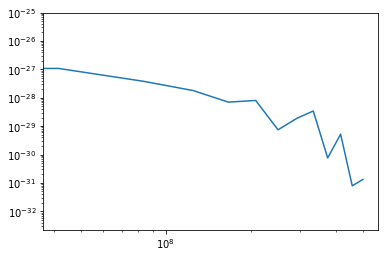

In [1460]:
plt.loglog(*PSD(S.Fpulse[:25], S.params["dt"]))
plt.ylim(top=1e-25)